In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr
import magali as mg
import numba
import choclo

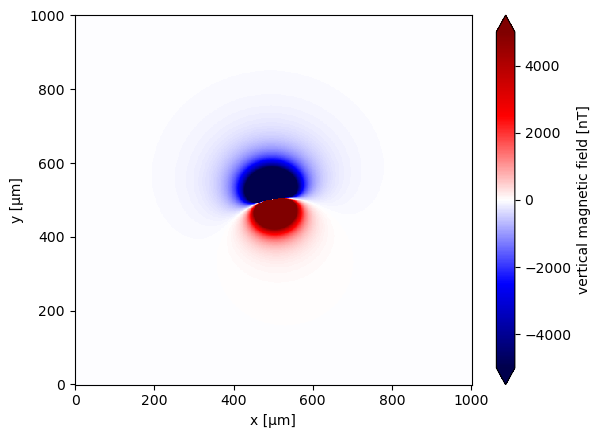

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 1000, 0, 1000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 1

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipole_coordinates = (500, 500, -15)

dipole_moments = hm.magnetic_angles_to_vec(
    inclination=-10,
    declination= 170,
    intensity= 5e-11
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [3]:
coordinates = vd.grid_coordinates(
    region=region,  # µm
    spacing=spacing,  # µm
    extra_coords=sensor_sample_distance,
)

In [4]:
coordinates[2]

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]], shape=(501, 501))

In [5]:
import numpy as np
import scipy as sp
import verde.base as vdb
import choclo  


def _calculate_jacobian(x, y, z, x_c, y_c, z_c):
    factor = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
    n_data = x.size
    n_params = 3 
    jacobian = [np.zeros(n_data) for _ in range(n_params)]
    
    for i in range(n_data):
        r = choclo.utils.distance_cartesian(x[i], y[i], z[i], x_c, y_c, z_c)
        
        kernel_eu = choclo.point.kernel_eu(x[i], y[i], z[i], x_c, y_c, z_c, r)
        kernel_nu = choclo.point.kernel_nu(x[i], y[i], z[i], x_c, y_c, z_c, r)
        kernel_uu = choclo.point.kernel_uu(x[i], y[i], z[i], x_c, y_c, z_c, r)

        jacobian[0][i] = factor * kernel_eu
        jacobian[1][i] = factor * kernel_nu
        jacobian[2][i] = factor * kernel_uu

    return np.array(jacobian)

class MagneticMomentBz:
    def __init__(self, location):
        self.location = location
        self.dipole_moment_ = None
        self.jacobian = None

    def fit(self, coordinates, data):
        coordinates, data, _ = vdb.check_fit_input(coordinates, data, weights=None)
        x, y, z = vdb.n_1d_arrays(coordinates, 3)
        x_c, y_c, z_c = vdb.n_1d_arrays(self.location, 3)
        

        jacobian = _calculate_jacobian(x, y, z, x_c, y_c, z_c)
        
        print("Jacobian:")
        print(jacobian)


inv = MagneticMomentBz(dipole_coordinates)
inv.fit(coordinates, data)


/tmp/ipykernel_2066/5047190.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jacobian[0][i] = factor * kernel_eu
/tmp/ipykernel_2066/5047190.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jacobian[1][i] = factor * kernel_nu
/tmp/ipykernel_2066/5047190.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jacobian[2][i] = factor * kernel_uu


Jacobian:
[[-1.69366691e-17 -1.70383210e-17 -1.71403032e-17 ...  1.71403032e-17
   1.70383210e-17  1.69366691e-17]
 [-1.69366691e-17 -1.71067480e-17 -1.72785315e-17 ...  1.72785315e-17
   1.71067480e-17  1.69366691e-17]
 [-2.81826174e-16 -2.83518117e-16 -2.85220174e-16 ... -2.85220174e-16
  -2.83518117e-16 -2.81826174e-16]]
